# CSCE 421 - Honors Final Project - Classifying Music Genres
### Name: Raiyan Bhuiya
### UIN: 827005857 

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
import tensorflow as tf
import torch

# Visualizing features

data refers to the sounds of the audio file which is the sequence of vibrations in different pressure strengths. sr is the the sample rate which refers to the number of samples of audio per second. The sample rate is meased in Hz or kHz

In [17]:
data, sr = librosa.load('Data/genres_original/blues/blues.00000.wav')

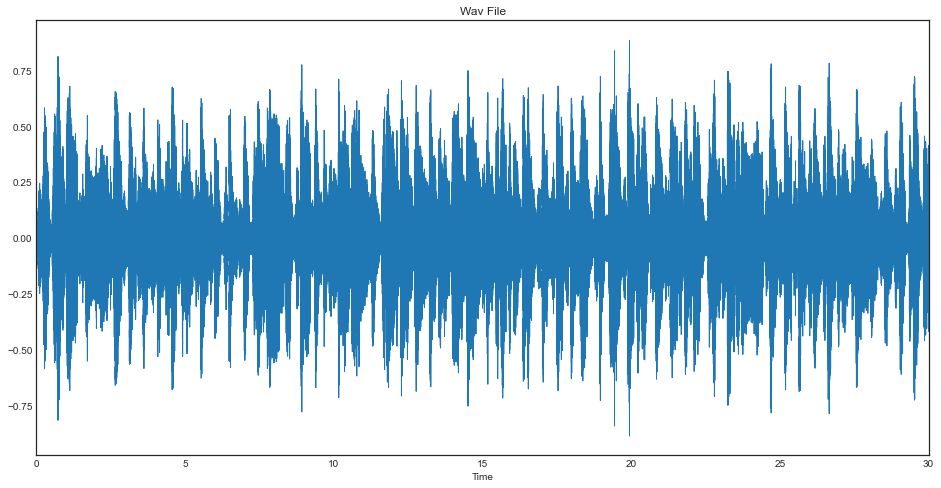

In [18]:
# Raw wave file
plt.figure(figsize=(16,8))
librosa.display.waveplot(data)
plt.title('Wav File');

## Chroma
Chromas represent the musical harmony of the song. They are categorized into the 12 semitones of the octave thus making them ignore the changes from using different instruments. Using the chroma, we can see the frequency of notes that are being played.

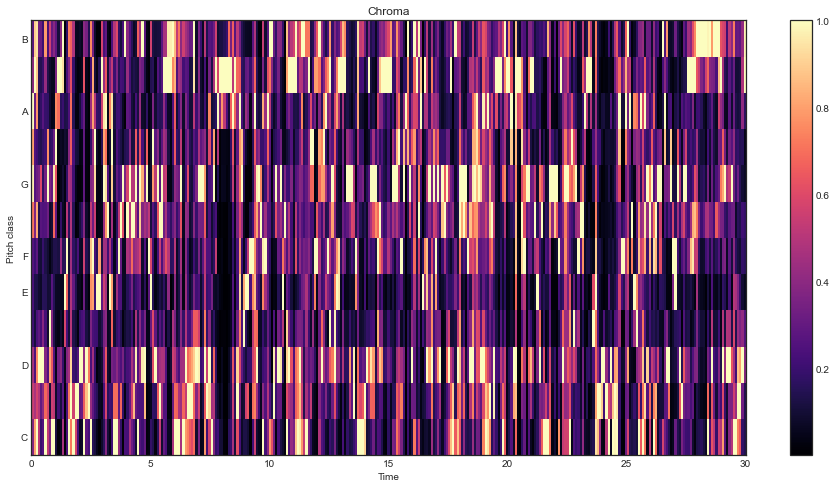

In [19]:
chroma = librosa.feature.chroma_stft(data, sr, hop_length=2000)
plt.figure(figsize=(16,8))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', hop_length=2000)
plt.colorbar()
plt.title('Chroma');

## Spectrogram
The spectrogram shows the audio files loudness at different frequencies. This can be used to find the energy levels of the song.

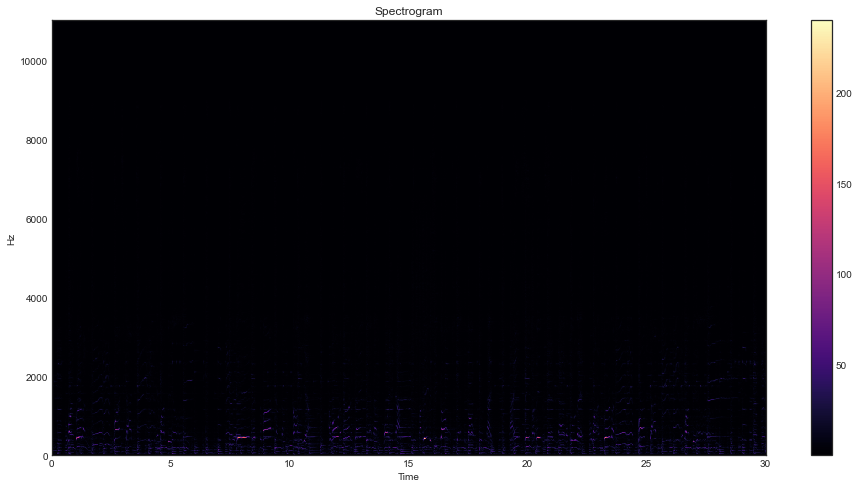

In [20]:
# Spectogram
spec = librosa.stft(data)
spec_db = librosa.amplitude_to_db(abs(spec))
plt.figure(figsize=(16,8))
librosa.display.specshow(spec, sr=sr, x_axis='time',y_axis='hz',cmap='magma')
plt.title('Spectrogram')
plt.colorbar();

## Spectral Centroid
The spectral centroid refers to where the sound is in terms of frequency. It is found by calculating the averages of the frequencies that are in the song.

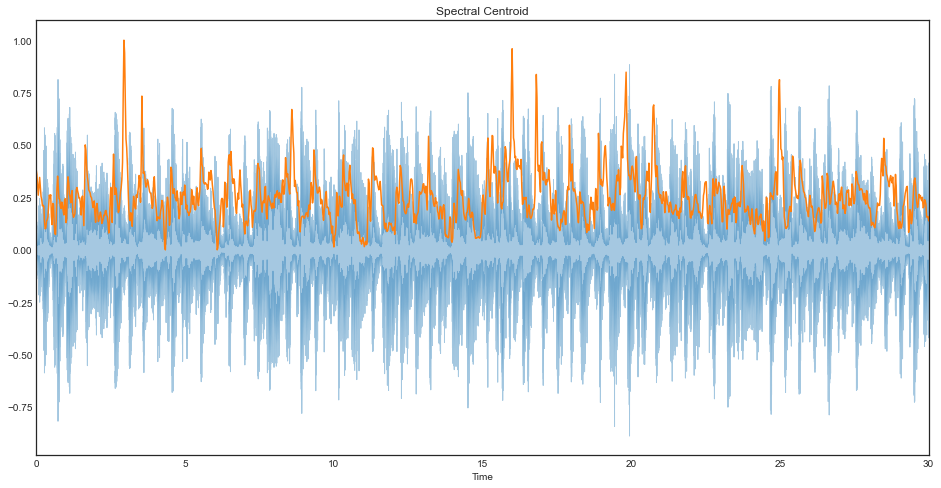

In [21]:
spec = librosa.feature.spectral_centroid(data, sr=sr)[0]
# Calculate length
f = range(len(spec))
time = librosa.frames_to_time(f)
plt.figure(figsize=(16,8))
librosa.display.waveplot(data, sr=sr, alpha=0.4)
spec = preprocessing.minmax_scale(spec, axis=0)
plt.title('Spectral Centroid')
plt.plot(time, spec);

## Zero crossing
Zero crossing is the number of times that the frequency crosses zero in the song.

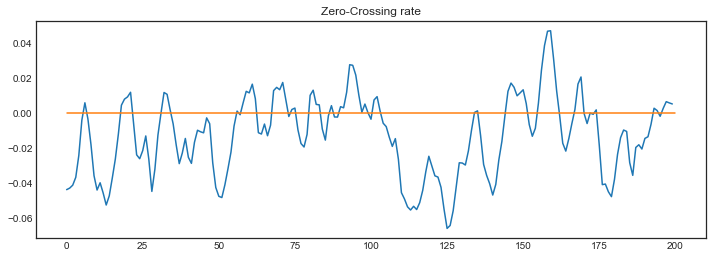

In [22]:
plt.figure(figsize=(12,4))
plt.plot(data[500:700])
plt.plot([0,200],[0,0])
plt.title('Zero-Crossing rate');

These features are available in the csv file for each of the audio files, which will be used to train our models.

# Applying PCA to data

In [23]:
# Normalize the data
data = pd.read_csv('Data/features_30_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [24]:
data = data.iloc[0:, 1:]
y = data['label']
X = data.drop('label', axis=1)

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns=cols)

pca = PCA(n_components=2)
# A 3rd PCA only increases the explained variance by 0.098 so it is not beneficial
pcomps = pca.fit_transform(X)
pDf = pd.DataFrame(data = pcomps, columns=['PC1', 'PC2'])

finalDf = pd.concat([pDf, y], axis=1)

pca.explained_variance_ratio_

array([0.2439355 , 0.21781804])

In [25]:
finalDf

,PC1,PC2,label
0,-0.394827,-0.115015,blues
1,0.050684,-0.271071,blues
2,-0.479969,-0.223169,blues
3,0.015376,-0.440066,blues
4,-0.162281,-0.508224,blues
...,...,...,...
995,-0.754686,-0.037197,rock
996,-0.810911,-0.028770,rock
997,-0.845392,-0.004622,rock
998,-0.235744,-0.372051,rock


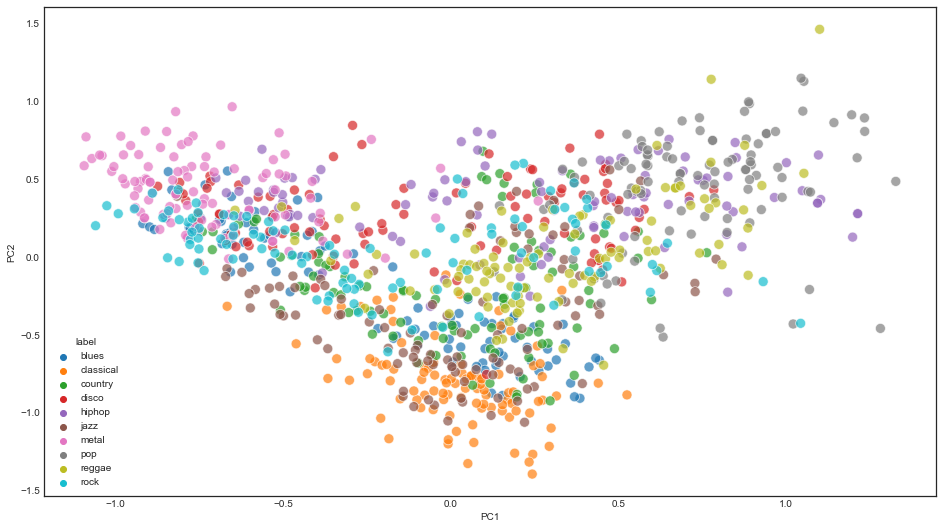

In [26]:
plt.figure(figsize=(16,9))
sns.scatterplot(x = 'PC1', y = 'PC2', data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

The csv file used about containes the features for each of the 30 sec audio files in each of the genres. There is a 3 sec csv file splitting the each row into another 10 rows resulting in more data to feed into the model. So this file will be used instead to train the models.

# Model Training

In [27]:
data = pd.read_csv('Data/features_3_sec.csv')
data = data.iloc[0:, 1:]
y = data['label']
X = data.drop('label', axis=1)

# Normalize x
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns=cols)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

## SVM Model

In [29]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
ypred = svm.predict(X_test)
acc = accuracy_score(y_test, ypred)

In [30]:
acc

0.732986389111289

In [31]:
# Poly kernel
tot_acc = []
for d in range(1,5):
    dacc = []
    for c in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        svm = SVC(kernel='poly', degree=d, C=c)
        svm.fit(X_train, y_train)
        ypred = svm.predict(X_test)
        acc = accuracy_score(y_test, ypred)
        print('Degree: ', d)
        print('C: ', c)
        print('Accuracy: ', acc)
        dacc.append(acc)
    tot_acc.append(dacc)

Degree:  1
C:  0.001
Accuracy:  0.09087269815852682
Degree:  1
C:  0.01
Accuracy:  0.3210568454763811
Degree:  1
C:  0.1
Accuracy:  0.5452361889511609
Degree:  1
C:  1
Accuracy:  0.7021617293835068
Degree:  1
C:  10
Accuracy:  0.7465972778222578
Degree:  1
C:  100
Accuracy:  0.7630104083266613
Degree:  1
C:  1000
Accuracy:  0.7710168134507606
Degree:  2
C:  0.001
Accuracy:  0.15252201761409126
Degree:  2
C:  0.01
Accuracy:  0.49039231385108084
Degree:  2
C:  0.1
Accuracy:  0.6697357886309048
Degree:  2
C:  1
Accuracy:  0.756204963971177
Degree:  2
C:  10
Accuracy:  0.8170536429143315
Degree:  2
C:  100
Accuracy:  0.8791032826261009
Degree:  2
C:  1000
Accuracy:  0.8863090472377902
Degree:  3
C:  0.001
Accuracy:  0.422337870296237
Degree:  3
C:  0.01
Accuracy:  0.6016813450760609
Degree:  3
C:  0.1
Accuracy:  0.7337870296236989
Degree:  3
C:  1
Accuracy:  0.8038430744595677
Degree:  3
C:  10
Accuracy:  0.8783026421136909
Degree:  3
C:  100
Accuracy:  0.8847077662129704
Degree:  3
C:  10

Degree 1: max accuracy =  0.7710168134507606 at c =  1000


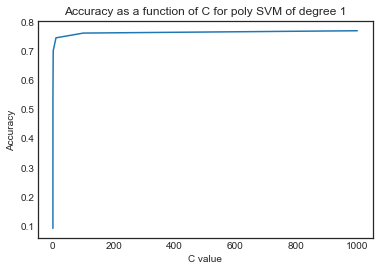

In [32]:
c = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
plt.plot(c, tot_acc[0])
plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of C for poly SVM of degree 1');
print('Degree 1: max accuracy = ', max(tot_acc[0]), 'at c = ', c[tot_acc[0].index(max(tot_acc[0]))])

Degree 2: max accuracy =  0.8863090472377902 at c =  1000


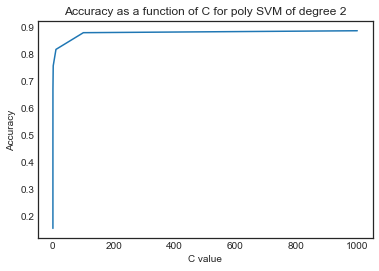

In [33]:
plt.plot(c, tot_acc[1])
plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of C for poly SVM of degree 2');
print('Degree 2: max accuracy = ', max(tot_acc[1]), 'at c = ', c[tot_acc[1].index(max(tot_acc[1]))])

Degree 3: max accuracy =  0.8847077662129704 at c =  100


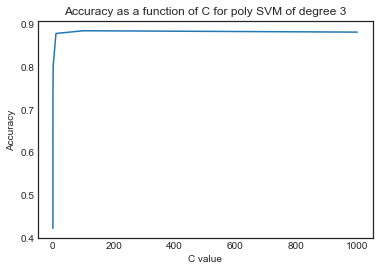

In [34]:
plt.plot(c, tot_acc[2])
plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of C for poly SVM of degree 3');
print('Degree 3: max accuracy = ', max(tot_acc[2]), 'at c = ', c[tot_acc[2].index(max(tot_acc[2]))])

Degree 4: max accuracy =  0.8895116092874299 at c =  10


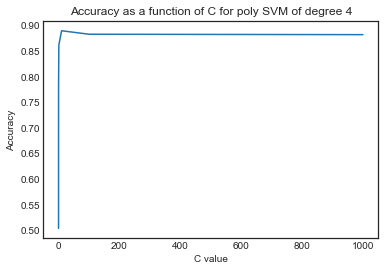

In [35]:
plt.plot(c, tot_acc[3])
plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of C for poly SVM of degree 4');
print('Degree 4: max accuracy = ', max(tot_acc[3]), 'at c = ', c[tot_acc[3].index(max(tot_acc[3]))])

The poly SVM of degree 2 had a similar accuracy rate compared to degree 4 but is more simpler so it is the optimal choice.

In [36]:
X = finalDf.drop('label', axis=1)
y = finalDf['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [37]:
# RBF svm on PCA data
svm = SVC(kernel='rbf').fit(X_train, y_train)
ypred = svm.predict(X_test)
acc = accuracy_score(y_test, ypred)
acc

0.36

In [38]:
# Poly SVM on PCA
svm = SVC(kernel='poly', degree=2, C=1000).fit(X_train, y_train)
ypred = svm.predict(X_test)
acc = accuracy_score(y_test, ypred)
acc

0.296

The models using the PCA perform poorly, this is mainly due to the PCA component only explaining around 50% of the variance in the data.

## CNN Model

In [39]:
y = data['label']
X = data.drop('label', axis=1)

# Normalize x
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns=cols)

y = preprocessing.LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [40]:
# Initialize model
model = Sequential([
   tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [41]:
# Train model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
epochs = [1, 25, 50, 100, 250, 500, 1000, 1500]
cnn_acc = []
for epoch in epochs:
    model.fit(X_train, y_train, epochs=epoch, batch_size=64)
    summary = model.evaluate(X_test, y_test, verbose=0, batch_size=64)
    cnn_acc.append(summary[1])

7492/7492 [==============================] - 1s 91us/sample - loss: 2.0538 - acc: 0.2407
Epoch 1/25
7492/7492 [==============================] - 0s 59us/sample - loss: 1.5955 - acc: 0.4076
Epoch 2/25
7492/7492 [==============================] - 0s 54us/sample - loss: 1.4408 - acc: 0.4685
Epoch 3/25
7492/7492 [==============================] - 0s 52us/sample - loss: 1.3506 - acc: 0.5111
Epoch 4/25
7492/7492 [==============================] - 0s 52us/sample - loss: 1.2578 - acc: 0.5519
Epoch 5/25
7492/7492 [==============================] - 0s 52us/sample - loss: 1.2055 - acc: 0.5683
Epoch 6/25
7492/7492 [==============================] - 0s 51us/sample - loss: 1.1579 - acc: 0.5900
Epoch 7/25
7492/7492 [==============================] - 0s 51us/sample - loss: 1.1019 - acc: 0.6156
Epoch 8/25
7492/7492 [==============================] - 0s 52us/sample - loss: 1.0574 - acc: 0.6381
Epoch 9/25
7492/7492 [==============================] - 0s 52us/sample - loss: 1.0275 - acc: 0.6438
Epoch 10/25

7492/7492 [==============================] - 0s 50us/sample - loss: 0.3805 - acc: 0.8775
Epoch 7/100
7492/7492 [==============================] - 0s 50us/sample - loss: 0.3922 - acc: 0.8699
Epoch 8/100
7492/7492 [==============================] - 0s 51us/sample - loss: 0.4305 - acc: 0.8568
Epoch 9/100
7492/7492 [==============================] - 0s 50us/sample - loss: 0.4029 - acc: 0.8664
Epoch 10/100
7492/7492 [==============================] - 0s 50us/sample - loss: 0.3876 - acc: 0.8731
Epoch 11/100
7492/7492 [==============================] - 0s 50us/sample - loss: 0.3632 - acc: 0.8823
Epoch 12/100
7492/7492 [==============================] - 0s 51us/sample - loss: 0.3903 - acc: 0.8751
Epoch 13/100
7492/7492 [==============================] - 0s 52us/sample - loss: 0.3496 - acc: 0.8861
Epoch 14/100
7492/7492 [==============================] - 0s 51us/sample - loss: 0.3741 - acc: 0.8763
Epoch 15/100
7492/7492 [==============================] - 0s 50us/sample - loss: 0.4175 - acc: 0.8

7492/7492 [==============================] - 0s 52us/sample - loss: 0.2464 - acc: 0.9231
Epoch 87/100
7492/7492 [==============================] - 0s 51us/sample - loss: 0.3496 - acc: 0.8910
Epoch 88/100
7492/7492 [==============================] - 0s 51us/sample - loss: 0.2821 - acc: 0.9095
Epoch 89/100
7492/7492 [==============================] - 0s 50us/sample - loss: 0.2518 - acc: 0.9172
Epoch 90/100
7492/7492 [==============================] - 0s 52us/sample - loss: 0.2508 - acc: 0.9136
Epoch 91/100
7492/7492 [==============================] - 0s 51us/sample - loss: 0.2542 - acc: 0.9154
Epoch 92/100
7492/7492 [==============================] - 0s 51us/sample - loss: 0.2314 - acc: 0.9278
Epoch 93/100
7492/7492 [==============================] - 0s 51us/sample - loss: 0.2264 - acc: 0.9246
Epoch 94/100
7492/7492 [==============================] - 0s 50us/sample - loss: 0.2634 - acc: 0.9168
Epoch 95/100
7492/7492 [==============================] - 0s 50us/sample - loss: 0.2423 - acc: 

7492/7492 [==============================] - 0s 52us/sample - loss: 0.2306 - acc: 0.9254
Epoch 67/250
7492/7492 [==============================] - 0s 50us/sample - loss: 0.2693 - acc: 0.9151
Epoch 68/250
7492/7492 [==============================] - 0s 50us/sample - loss: 0.2605 - acc: 0.9192
Epoch 69/250
7492/7492 [==============================] - 0s 50us/sample - loss: 0.2307 - acc: 0.9242
Epoch 70/250
7492/7492 [==============================] - 0s 50us/sample - loss: 0.2265 - acc: 0.9283
Epoch 71/250
7492/7492 [==============================] - 0s 52us/sample - loss: 0.2192 - acc: 0.9327
Epoch 72/250
7492/7492 [==============================] - 0s 52us/sample - loss: 0.2173 - acc: 0.9321
Epoch 73/250
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1961 - acc: 0.9347
Epoch 74/250
7492/7492 [==============================] - 0s 50us/sample - loss: 0.2271 - acc: 0.9282
Epoch 75/250
7492/7492 [==============================] - 0s 52us/sample - loss: 0.2135 - acc: 

Epoch 146/250
7492/7492 [==============================] - 0s 53us/sample - loss: 0.1767 - acc: 0.9457
Epoch 147/250
7492/7492 [==============================] - 0s 51us/sample - loss: 0.2142 - acc: 0.9337
Epoch 148/250
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1809 - acc: 0.9445
Epoch 149/250
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1696 - acc: 0.9442
Epoch 150/250
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1770 - acc: 0.9443
Epoch 151/250
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1586 - acc: 0.9482
Epoch 152/250
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1904 - acc: 0.9367
Epoch 153/250
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1621 - acc: 0.9490
Epoch 154/250
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1523 - acc: 0.9530
Epoch 155/250
7492/7492 [==============================] - 0s 51us/sample

7492/7492 [==============================] - 0s 50us/sample - loss: 0.1759 - acc: 0.9439
Epoch 226/250
7492/7492 [==============================] - 0s 51us/sample - loss: 0.2164 - acc: 0.9323
Epoch 227/250
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1568 - acc: 0.9536
Epoch 228/250
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1535 - acc: 0.9522
Epoch 229/250
7492/7492 [==============================] - 0s 51us/sample - loss: 0.2242 - acc: 0.9293
Epoch 230/250
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1500 - acc: 0.9511
Epoch 231/250
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1672 - acc: 0.9447
Epoch 232/250
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1807 - acc: 0.9450
Epoch 233/250
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1529 - acc: 0.9506
Epoch 234/250
7492/7492 [==============================] - 0s 52us/sample - loss: 0.152

7492/7492 [==============================] - 0s 59us/sample - loss: 0.1392 - acc: 0.9572
Epoch 56/500
7492/7492 [==============================] - 0s 59us/sample - loss: 0.1283 - acc: 0.9578
Epoch 57/500
7492/7492 [==============================] - 0s 54us/sample - loss: 0.1125 - acc: 0.9654
Epoch 58/500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1416 - acc: 0.9546
Epoch 59/500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1176 - acc: 0.9654
Epoch 60/500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.1415 - acc: 0.9585
Epoch 61/500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.1417 - acc: 0.9582
Epoch 62/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1191 - acc: 0.9602
Epoch 63/500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1148 - acc: 0.9657
Epoch 64/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1211 - acc: 

7492/7492 [==============================] - 0s 51us/sample - loss: 0.1262 - acc: 0.9600
Epoch 136/500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1200 - acc: 0.9617
Epoch 137/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1356 - acc: 0.9576
Epoch 138/500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.1258 - acc: 0.9662
Epoch 139/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1134 - acc: 0.9673
Epoch 140/500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1189 - acc: 0.9612
Epoch 141/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0998 - acc: 0.9681
Epoch 142/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1092 - acc: 0.9660
Epoch 143/500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1231 - acc: 0.9634
Epoch 144/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.121

7492/7492 [==============================] - 0s 51us/sample - loss: 0.1270 - acc: 0.9633
Epoch 215/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1082 - acc: 0.9676
Epoch 216/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1000 - acc: 0.9690
Epoch 217/500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.1029 - acc: 0.9697
Epoch 218/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0992 - acc: 0.9692
Epoch 219/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1161 - acc: 0.9672
Epoch 220/500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1321 - acc: 0.9578
Epoch 221/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1033 - acc: 0.9688
Epoch 222/500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1090 - acc: 0.9682
Epoch 223/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.091

7492/7492 [==============================] - 0s 52us/sample - loss: 0.0980 - acc: 0.9709
Epoch 294/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0941 - acc: 0.9714
Epoch 295/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1084 - acc: 0.9658
Epoch 296/500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.1131 - acc: 0.9657
Epoch 297/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1058 - acc: 0.9688
Epoch 298/500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0884 - acc: 0.9746
Epoch 299/500
7492/7492 [==============================] - 0s 58us/sample - loss: 0.0906 - acc: 0.9733
Epoch 300/500
7492/7492 [==============================] - 0s 57us/sample - loss: 0.0878 - acc: 0.9737
Epoch 301/500
7492/7492 [==============================] - 0s 56us/sample - loss: 0.1048 - acc: 0.9689
Epoch 302/500
7492/7492 [==============================] - 0s 56us/sample - loss: 0.080

7492/7492 [==============================] - 0s 52us/sample - loss: 0.1153 - acc: 0.9660
Epoch 373/500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0989 - acc: 0.9689
Epoch 374/500
7492/7492 [==============================] - 0s 54us/sample - loss: 0.0929 - acc: 0.9729
Epoch 375/500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0818 - acc: 0.9754
Epoch 376/500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0798 - acc: 0.9749
Epoch 377/500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.1003 - acc: 0.9721
Epoch 378/500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.1058 - acc: 0.9656
Epoch 379/500
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0870 - acc: 0.9744
Epoch 380/500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.2139 - acc: 0.9370
Epoch 381/500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.128

7492/7492 [==============================] - 0s 51us/sample - loss: 0.0767 - acc: 0.9766
Epoch 452/500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0884 - acc: 0.9722
Epoch 453/500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0998 - acc: 0.9704
Epoch 454/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0763 - acc: 0.9776
Epoch 455/500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.1004 - acc: 0.9682
Epoch 456/500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0727 - acc: 0.9768
Epoch 457/500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.1141 - acc: 0.9682
Epoch 458/500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0758 - acc: 0.9765
Epoch 459/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0872 - acc: 0.9710
Epoch 460/500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.092

7492/7492 [==============================] - 0s 51us/sample - loss: 0.0926 - acc: 0.9734
Epoch 31/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0724 - acc: 0.9770
Epoch 32/1000
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0805 - acc: 0.9756
Epoch 33/1000
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0876 - acc: 0.9737
Epoch 34/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0557 - acc: 0.9830
Epoch 35/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0675 - acc: 0.9786
Epoch 36/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0982 - acc: 0.9704
Epoch 37/1000
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0845 - acc: 0.9741
Epoch 38/1000
7492/7492 [==============================] - 0s 50us/sample - loss: 0.1305 - acc: 0.9610
Epoch 39/1000
7492/7492 [==============================] - 0s 50us/sample - loss: 0.094

7492/7492 [==============================] - 0s 52us/sample - loss: 0.0426 - acc: 0.9868
Epoch 110/1000
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0756 - acc: 0.9777
Epoch 111/1000
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0744 - acc: 0.9784
Epoch 112/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0816 - acc: 0.9758
Epoch 113/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0959 - acc: 0.9716
Epoch 114/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0833 - acc: 0.9738
Epoch 115/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0714 - acc: 0.9769
Epoch 116/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0934 - acc: 0.9708
Epoch 117/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0708 - acc: 0.9801
Epoch 118/1000
7492/7492 [==============================] - 0s 53us/sample - lo

7492/7492 [==============================] - 0s 51us/sample - loss: 0.0804 - acc: 0.9766
Epoch 188/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0800 - acc: 0.9750
Epoch 189/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0680 - acc: 0.9792
Epoch 190/1000
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0622 - acc: 0.9809
Epoch 191/1000
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0718 - acc: 0.9780
Epoch 192/1000
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0756 - acc: 0.9778
Epoch 193/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0456 - acc: 0.9861
Epoch 194/1000
7492/7492 [==============================] - 0s 54us/sample - loss: 0.0596 - acc: 0.9820
Epoch 195/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0755 - acc: 0.9769
Epoch 196/1000
7492/7492 [==============================] - 0s 50us/sample - lo

7492/7492 [==============================] - 0s 51us/sample - loss: 0.0633 - acc: 0.9800
Epoch 266/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0745 - acc: 0.9780
Epoch 267/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0776 - acc: 0.9784
Epoch 268/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0585 - acc: 0.9821
Epoch 269/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0571 - acc: 0.9813
Epoch 270/1000
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0780 - acc: 0.9777
Epoch 271/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0570 - acc: 0.9845
Epoch 272/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0753 - acc: 0.9765
Epoch 273/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0678 - acc: 0.9805
Epoch 274/1000
7492/7492 [==============================] - 0s 51us/sample - lo

7492/7492 [==============================] - 0s 51us/sample - loss: 0.0711 - acc: 0.9778
Epoch 344/1000
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0629 - acc: 0.9821
Epoch 345/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0818 - acc: 0.9765
Epoch 346/1000
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0756 - acc: 0.9762
Epoch 347/1000
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0918 - acc: 0.9744
Epoch 348/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0582 - acc: 0.9838
Epoch 349/1000
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0451 - acc: 0.9853
Epoch 350/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0572 - acc: 0.9829
Epoch 351/1000
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0708 - acc: 0.9786
Epoch 352/1000
7492/7492 [==============================] - 0s 50us/sample - lo

7492/7492 [==============================] - 0s 51us/sample - loss: 0.0607 - acc: 0.9825
Epoch 422/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0654 - acc: 0.9826
Epoch 423/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0656 - acc: 0.9816
Epoch 424/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0845 - acc: 0.9777
Epoch 425/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0607 - acc: 0.9833
Epoch 426/1000
7492/7492 [==============================] - 0s 54us/sample - loss: 0.0521 - acc: 0.9860
Epoch 427/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0522 - acc: 0.9847
Epoch 428/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0454 - acc: 0.9865
Epoch 429/1000
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0744 - acc: 0.9776
Epoch 430/1000
7492/7492 [==============================] - 0s 53us/sample - lo

7492/7492 [==============================] - 0s 51us/sample - loss: 0.0730 - acc: 0.9789
Epoch 500/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0569 - acc: 0.9842
Epoch 501/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0449 - acc: 0.9873
Epoch 502/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0626 - acc: 0.9808
Epoch 503/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0477 - acc: 0.9856
Epoch 504/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0649 - acc: 0.9798
Epoch 505/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0621 - acc: 0.9817
Epoch 506/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0558 - acc: 0.9844
Epoch 507/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0663 - acc: 0.9798
Epoch 508/1000
7492/7492 [==============================] - 0s 52us/sample - lo

7492/7492 [==============================] - 0s 53us/sample - loss: 0.0586 - acc: 0.9824
Epoch 578/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0608 - acc: 0.9813
Epoch 579/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0612 - acc: 0.9809
Epoch 580/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0709 - acc: 0.9796
Epoch 581/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0426 - acc: 0.9863
Epoch 582/1000
7492/7492 [==============================] - 0s 54us/sample - loss: 0.0738 - acc: 0.9789
Epoch 583/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0561 - acc: 0.9832
Epoch 584/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0562 - acc: 0.9847
Epoch 585/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0629 - acc: 0.9802
Epoch 586/1000
7492/7492 [==============================] - 0s 52us/sample - lo

7492/7492 [==============================] - 0s 52us/sample - loss: 0.0576 - acc: 0.9828
Epoch 656/1000
7492/7492 [==============================] - 0s 54us/sample - loss: 0.0655 - acc: 0.9804
Epoch 657/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0561 - acc: 0.9849
Epoch 658/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0930 - acc: 0.9756
Epoch 659/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0618 - acc: 0.9822
Epoch 660/1000
7492/7492 [==============================] - 0s 54us/sample - loss: 0.0657 - acc: 0.9810
Epoch 661/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0568 - acc: 0.9830
Epoch 662/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0512 - acc: 0.9842
Epoch 663/1000
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0605 - acc: 0.9832
Epoch 664/1000
7492/7492 [==============================] - 0s 53us/sample - lo

7492/7492 [==============================] - 0s 51us/sample - loss: 0.0534 - acc: 0.9848
Epoch 734/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0625 - acc: 0.9825
Epoch 735/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0372 - acc: 0.9884
Epoch 736/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0568 - acc: 0.9847
Epoch 737/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0523 - acc: 0.9838
Epoch 738/1000
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0601 - acc: 0.9821
Epoch 739/1000
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0407 - acc: 0.9873
Epoch 740/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0453 - acc: 0.9868
Epoch 741/1000
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0626 - acc: 0.9832
Epoch 742/1000
7492/7492 [==============================] - 0s 52us/sample - lo

7492/7492 [==============================] - 0s 53us/sample - loss: 0.0586 - acc: 0.9841
Epoch 812/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0566 - acc: 0.9840
Epoch 813/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0525 - acc: 0.9838
Epoch 814/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0433 - acc: 0.9880
Epoch 815/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0579 - acc: 0.9818
Epoch 816/1000
7492/7492 [==============================] - 0s 54us/sample - loss: 0.0436 - acc: 0.9881
Epoch 817/1000
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0506 - acc: 0.9861
Epoch 818/1000
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0382 - acc: 0.9893
Epoch 819/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0476 - acc: 0.9860
Epoch 820/1000
7492/7492 [==============================] - 0s 52us/sample - lo

7492/7492 [==============================] - 0s 52us/sample - loss: 0.0520 - acc: 0.9861
Epoch 890/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0493 - acc: 0.9856
Epoch 891/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0559 - acc: 0.9848
Epoch 892/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0566 - acc: 0.9814
Epoch 893/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0576 - acc: 0.9836
Epoch 894/1000
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0527 - acc: 0.9836
Epoch 895/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0388 - acc: 0.9904
Epoch 896/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0529 - acc: 0.9830
Epoch 897/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0585 - acc: 0.9841
Epoch 898/1000
7492/7492 [==============================] - 0s 52us/sample - lo

7492/7492 [==============================] - 0s 51us/sample - loss: 0.0345 - acc: 0.9892
Epoch 968/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0353 - acc: 0.9893
Epoch 969/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0518 - acc: 0.9859
Epoch 970/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0408 - acc: 0.9881
Epoch 971/1000
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0496 - acc: 0.9840
Epoch 972/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0633 - acc: 0.9830
Epoch 973/1000
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0515 - acc: 0.9856
Epoch 974/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0495 - acc: 0.9859
Epoch 975/1000
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0587 - acc: 0.9857
Epoch 976/1000
7492/7492 [==============================] - 0s 51us/sample - lo

7492/7492 [==============================] - 0s 51us/sample - loss: 0.0461 - acc: 0.9879
Epoch 47/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0689 - acc: 0.9804
Epoch 48/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0609 - acc: 0.9824
Epoch 49/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0428 - acc: 0.9865
Epoch 50/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0391 - acc: 0.9881
Epoch 51/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0567 - acc: 0.9821
Epoch 52/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0622 - acc: 0.9821
Epoch 53/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0487 - acc: 0.9859
Epoch 54/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0467 - acc: 0.9868
Epoch 55/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.052

7492/7492 [==============================] - 0s 51us/sample - loss: 0.0408 - acc: 0.9877
Epoch 126/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0416 - acc: 0.9869
Epoch 127/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0754 - acc: 0.9782
Epoch 128/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0442 - acc: 0.9867
Epoch 129/1500
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0591 - acc: 0.9830
Epoch 130/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0711 - acc: 0.9798
Epoch 131/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0613 - acc: 0.9849
Epoch 132/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0416 - acc: 0.9867
Epoch 133/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0561 - acc: 0.9824
Epoch 134/1500
7492/7492 [==============================] - 0s 51us/sample - lo

7492/7492 [==============================] - 0s 52us/sample - loss: 0.0427 - acc: 0.9869
Epoch 204/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0530 - acc: 0.9844
Epoch 205/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0791 - acc: 0.9773
Epoch 206/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0600 - acc: 0.9838
Epoch 207/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0569 - acc: 0.9852
Epoch 208/1500
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0426 - acc: 0.9883
Epoch 209/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0421 - acc: 0.9873
Epoch 210/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0324 - acc: 0.9912
Epoch 211/1500
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0553 - acc: 0.9833
Epoch 212/1500
7492/7492 [==============================] - 0s 51us/sample - lo

7492/7492 [==============================] - 0s 51us/sample - loss: 0.0651 - acc: 0.9816
Epoch 282/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0504 - acc: 0.9856
Epoch 283/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0419 - acc: 0.9884
Epoch 284/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0384 - acc: 0.9888
Epoch 285/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0447 - acc: 0.9891
Epoch 286/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0456 - acc: 0.9869
Epoch 287/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0451 - acc: 0.9856
Epoch 288/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0472 - acc: 0.9845
Epoch 289/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0489 - acc: 0.9865
Epoch 290/1500
7492/7492 [==============================] - 0s 52us/sample - lo

7492/7492 [==============================] - 0s 51us/sample - loss: 0.0697 - acc: 0.9828
Epoch 360/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0494 - acc: 0.9852
Epoch 361/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0624 - acc: 0.9834
Epoch 362/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0486 - acc: 0.9853
Epoch 363/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0396 - acc: 0.9881
Epoch 364/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0443 - acc: 0.9885
Epoch 365/1500
7492/7492 [==============================] - 0s 56us/sample - loss: 0.0485 - acc: 0.9853
Epoch 366/1500
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0390 - acc: 0.9899
Epoch 367/1500
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0425 - acc: 0.9883
Epoch 368/1500
7492/7492 [==============================] - 0s 53us/sample - lo

7492/7492 [==============================] - 0s 53us/sample - loss: 0.0443 - acc: 0.9833
Epoch 438/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.1222 - acc: 0.9652
Epoch 439/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0549 - acc: 0.9837
Epoch 440/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0592 - acc: 0.9818
Epoch 441/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0445 - acc: 0.9873
Epoch 442/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0497 - acc: 0.9855
Epoch 443/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0518 - acc: 0.9856
Epoch 444/1500
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0466 - acc: 0.9869
Epoch 445/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0589 - acc: 0.9836
Epoch 446/1500
7492/7492 [==============================] - 0s 52us/sample - lo

7492/7492 [==============================] - 0s 51us/sample - loss: 0.0394 - acc: 0.9884
Epoch 516/1500
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0801 - acc: 0.9786
Epoch 517/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0472 - acc: 0.9871
Epoch 518/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0439 - acc: 0.9860
Epoch 519/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0532 - acc: 0.9864
Epoch 520/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0392 - acc: 0.9884
Epoch 521/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0516 - acc: 0.9860
Epoch 522/1500
7492/7492 [==============================] - 0s 54us/sample - loss: 0.0997 - acc: 0.9730
Epoch 523/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0499 - acc: 0.9873
Epoch 524/1500
7492/7492 [==============================] - 0s 51us/sample - lo

7492/7492 [==============================] - 0s 52us/sample - loss: 0.0339 - acc: 0.9903
Epoch 594/1500
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0364 - acc: 0.9891
Epoch 595/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0497 - acc: 0.9853
Epoch 596/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0393 - acc: 0.9876
Epoch 597/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0411 - acc: 0.9876
Epoch 598/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0488 - acc: 0.9853
Epoch 599/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0409 - acc: 0.9868
Epoch 600/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0345 - acc: 0.9897
Epoch 601/1500
7492/7492 [==============================] - 0s 54us/sample - loss: 0.0534 - acc: 0.9856
Epoch 602/1500
7492/7492 [==============================] - 0s 52us/sample - lo

7492/7492 [==============================] - 0s 57us/sample - loss: 0.0564 - acc: 0.9860
Epoch 672/1500
7492/7492 [==============================] - 0s 57us/sample - loss: 0.0512 - acc: 0.9861
Epoch 673/1500
7492/7492 [==============================] - 0s 56us/sample - loss: 0.0436 - acc: 0.9877
Epoch 674/1500
7492/7492 [==============================] - 0s 56us/sample - loss: 0.0734 - acc: 0.9812
Epoch 675/1500
7492/7492 [==============================] - 0s 55us/sample - loss: 0.0403 - acc: 0.9880
Epoch 676/1500
7492/7492 [==============================] - 0s 55us/sample - loss: 0.0331 - acc: 0.9904
Epoch 677/1500
7492/7492 [==============================] - 0s 56us/sample - loss: 0.0439 - acc: 0.9879
Epoch 678/1500
7492/7492 [==============================] - 0s 58us/sample - loss: 0.0342 - acc: 0.9901
Epoch 679/1500
7492/7492 [==============================] - 0s 55us/sample - loss: 0.0478 - acc: 0.9871
Epoch 680/1500
7492/7492 [==============================] - 0s 57us/sample - lo

7492/7492 [==============================] - 0s 52us/sample - loss: 0.0571 - acc: 0.9838
Epoch 750/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0436 - acc: 0.9876
Epoch 751/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0462 - acc: 0.9884
Epoch 752/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0598 - acc: 0.9833
Epoch 753/1500
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0571 - acc: 0.9832
Epoch 754/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0365 - acc: 0.9899
Epoch 755/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0409 - acc: 0.9889
Epoch 756/1500
7492/7492 [==============================] - 0s 59us/sample - loss: 0.0606 - acc: 0.9834
Epoch 757/1500
7492/7492 [==============================] - 0s 65us/sample - loss: 0.0515 - acc: 0.9860
Epoch 758/1500
7492/7492 [==============================] - 0s 55us/sample - lo

7492/7492 [==============================] - 0s 55us/sample - loss: 0.0323 - acc: 0.9908
Epoch 828/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0515 - acc: 0.9859
Epoch 829/1500
7492/7492 [==============================] - 0s 59us/sample - loss: 0.0352 - acc: 0.9888
Epoch 830/1500
7492/7492 [==============================] - 0s 66us/sample - loss: 0.0413 - acc: 0.9893
Epoch 831/1500
7492/7492 [==============================] - 1s 77us/sample - loss: 0.0541 - acc: 0.9860
Epoch 832/1500
7492/7492 [==============================] - 1s 79us/sample - loss: 0.0427 - acc: 0.9877
Epoch 833/1500
7492/7492 [==============================] - 1s 79us/sample - loss: 0.0587 - acc: 0.9856
Epoch 834/1500
7492/7492 [==============================] - 1s 69us/sample - loss: 0.0370 - acc: 0.9879
Epoch 835/1500
7492/7492 [==============================] - 0s 56us/sample - loss: 0.0411 - acc: 0.9884
Epoch 836/1500
7492/7492 [==============================] - 0s 53us/sample - lo

7492/7492 [==============================] - 0s 50us/sample - loss: 0.0354 - acc: 0.9887
Epoch 906/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0482 - acc: 0.9861
Epoch 907/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0263 - acc: 0.9919
Epoch 908/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0462 - acc: 0.9864
Epoch 909/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0375 - acc: 0.9889
Epoch 910/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0414 - acc: 0.9888
Epoch 911/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0377 - acc: 0.9893
Epoch 912/1500
7492/7492 [==============================] - 0s 49us/sample - loss: 0.0472 - acc: 0.9856
Epoch 913/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0959 - acc: 0.9753
Epoch 914/1500
7492/7492 [==============================] - 0s 52us/sample - lo

7492/7492 [==============================] - 1s 75us/sample - loss: 0.0269 - acc: 0.9924
Epoch 984/1500
7492/7492 [==============================] - 1s 76us/sample - loss: 0.0400 - acc: 0.9904
Epoch 985/1500
7492/7492 [==============================] - 1s 88us/sample - loss: 0.0394 - acc: 0.9887
Epoch 986/1500
7492/7492 [==============================] - 1s 87us/sample - loss: 0.0404 - acc: 0.9899
Epoch 987/1500
7492/7492 [==============================] - 0s 59us/sample - loss: 0.0457 - acc: 0.9872
Epoch 988/1500
7492/7492 [==============================] - 0s 56us/sample - loss: 0.0534 - acc: 0.9848
Epoch 989/1500
7492/7492 [==============================] - 0s 62us/sample - loss: 0.0418 - acc: 0.9885
Epoch 990/1500
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0311 - acc: 0.9907
Epoch 991/1500
7492/7492 [==============================] - 0s 55us/sample - loss: 0.0410 - acc: 0.9881
Epoch 992/1500
7492/7492 [==============================] - 1s 75us/sample - lo

7492/7492 [==============================] - 0s 50us/sample - loss: 0.0531 - acc: 0.9856
Epoch 1062/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0410 - acc: 0.9891
Epoch 1063/1500
7492/7492 [==============================] - 0s 49us/sample - loss: 0.0362 - acc: 0.9900
Epoch 1064/1500
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0294 - acc: 0.9923
Epoch 1065/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0273 - acc: 0.9909
Epoch 1066/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0451 - acc: 0.9873
Epoch 1067/1500
7492/7492 [==============================] - 0s 59us/sample - loss: 0.0363 - acc: 0.9891
Epoch 1068/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0313 - acc: 0.9919
Epoch 1069/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0377 - acc: 0.9881
Epoch 1070/1500
7492/7492 [==============================] - 0s 57us/sa

7492/7492 [==============================] - 0s 52us/sample - loss: 0.0306 - acc: 0.9911
Epoch 1139/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0363 - acc: 0.9884
Epoch 1140/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0449 - acc: 0.9876
Epoch 1141/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0345 - acc: 0.9893
Epoch 1142/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0395 - acc: 0.9880
Epoch 1143/1500
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0286 - acc: 0.9909
Epoch 1144/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0497 - acc: 0.9871
Epoch 1145/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0559 - acc: 0.9852
Epoch 1146/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0460 - acc: 0.9879
Epoch 1147/1500
7492/7492 [==============================] - 0s 51us/sa

7492/7492 [==============================] - 0s 50us/sample - loss: 0.0380 - acc: 0.9893
Epoch 1217/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0338 - acc: 0.9899
Epoch 1218/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0273 - acc: 0.9920
Epoch 1219/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0427 - acc: 0.9884
Epoch 1220/1500
7492/7492 [==============================] - 0s 49us/sample - loss: 0.0299 - acc: 0.9908
Epoch 1221/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0331 - acc: 0.9909
Epoch 1222/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0510 - acc: 0.9856
Epoch 1223/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0420 - acc: 0.9871
Epoch 1224/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0345 - acc: 0.9903
Epoch 1225/1500
7492/7492 [==============================] - 0s 50us/sa

7492/7492 [==============================] - 0s 54us/sample - loss: 0.0410 - acc: 0.9896
Epoch 1295/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0506 - acc: 0.9851
Epoch 1296/1500
7492/7492 [==============================] - 0s 52us/sample - loss: 0.0621 - acc: 0.9821
Epoch 1297/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0370 - acc: 0.9896
Epoch 1298/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0465 - acc: 0.9881
Epoch 1299/1500
7492/7492 [==============================] - 0s 49us/sample - loss: 0.0349 - acc: 0.9911
Epoch 1300/1500
7492/7492 [==============================] - 0s 49us/sample - loss: 0.0379 - acc: 0.9891
Epoch 1301/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0251 - acc: 0.9931
Epoch 1302/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0329 - acc: 0.9913
Epoch 1303/1500
7492/7492 [==============================] - 0s 51us/sa

7492/7492 [==============================] - 0s 50us/sample - loss: 0.0267 - acc: 0.9927
Epoch 1373/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0310 - acc: 0.9904
Epoch 1374/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0337 - acc: 0.9900
Epoch 1375/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0268 - acc: 0.9915
Epoch 1376/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0469 - acc: 0.9888
Epoch 1377/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0516 - acc: 0.9852
Epoch 1378/1500
7492/7492 [==============================] - 0s 50us/sample - loss: 0.0346 - acc: 0.9892
Epoch 1379/1500
7492/7492 [==============================] - 0s 49us/sample - loss: 0.0380 - acc: 0.9900
Epoch 1380/1500
7492/7492 [==============================] - 0s 49us/sample - loss: 0.0396 - acc: 0.9883
Epoch 1381/1500
7492/7492 [==============================] - 0s 51us/sa

7492/7492 [==============================] - 0s 53us/sample - loss: 0.0392 - acc: 0.9880
Epoch 1450/1500
7492/7492 [==============================] - 0s 67us/sample - loss: 0.0419 - acc: 0.9887
Epoch 1451/1500
7492/7492 [==============================] - 1s 78us/sample - loss: 0.0461 - acc: 0.9869
Epoch 1452/1500
7492/7492 [==============================] - 0s 62us/sample - loss: 0.0234 - acc: 0.9927
Epoch 1453/1500
7492/7492 [==============================] - 0s 55us/sample - loss: 0.0497 - acc: 0.9864
Epoch 1454/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0291 - acc: 0.9925
Epoch 1455/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0312 - acc: 0.9912
Epoch 1456/1500
7492/7492 [==============================] - 0s 51us/sample - loss: 0.0266 - acc: 0.9921
Epoch 1457/1500
7492/7492 [==============================] - 0s 53us/sample - loss: 0.0239 - acc: 0.9927
Epoch 1458/1500
7492/7492 [==============================] - 0s 53us/sa

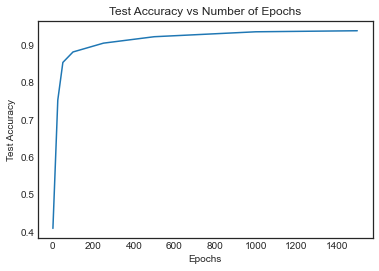

In [42]:
plt.plot(epochs, cnn_acc)
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Number of Epochs');

In [43]:
max(cnn_acc)

0.9383507

Max of 0.93 accuracy was achieved with 250 epochs